# Test trained model on sample CT images

In [1]:
import torch
import torchvision.transforms.functional as F

from utils.function_lib import *
from utils.DiceLoss import *

from pydicom import dcmread
from pydicom.encaps import encapsulate
from pydicom.pixel_data_handlers.util import apply_modality_lut

import os

from ModelBuilder.ResNet152_DeepLab import ResNet152DeepLab
from ModelBuilder.ResNeXt101_DeepLab import ResNeXt101DeepLab
from FusionSystem.FusionNetwork import FusionNetwork
# %matplotlib widget

## Input transform

In [2]:
transform_image = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True),
     transforms.ToTensor(), 
     transforms.Normalize(mean=[0.2], std=[0.2])
     ])

## Init model

In [3]:
# device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = FusionNetwork()
# checkpoint = torch.load('G:/MachineLearning/models/ResNet152/ResNet152_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

FusionNetwork(
  (resnet): ResNet152DeepLab(
    (FeatureExtractor): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Segmentare imagini

In [5]:
load_path = 'G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study/'
dicom_files = glob.glob(load_path + '*NESEGMENTAT*/*')
img_stack = []

window_min = -250.0
window_max = 250.0

for dicom_path in dicom_files:
    datastore = dcmread(dicom_path)
    image = datastore.pixel_array
    image = apply_modality_lut(image, datastore)
    image = image.astype(np.float32)

    # image = np.flip(image, 0)
    # image = np.flip(image, 1)
    image[image < window_min] = window_min
    image[image > window_max] = window_max
    image = (image - window_min) / (window_max - window_min)
    init_image = torch.tensor(image)
    init_size = init_image.shape[0]
    # m, s = np.mean(image), np.std(image)
    # print(f"Mean: {m}, StdDev: {s}")
    transform_image = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.Resize(256, interpolation=transforms.functional.InterpolationMode.BILINEAR, antialias=True),
         transforms.ToTensor(),
         transforms.Normalize(mean=0.2, std=0.2)
         ])

    input_tensor = transform_image(image)
    input_batch = input_tensor.repeat(2, 1, 1, 1)
    input_batch = input_batch.to(device)
    with torch.no_grad():
        output = model(input_batch)[0]
    image, mask = deprocess_img(input_tensor, output, init_size)
    mask = torch.sigmoid(mask)
    mask = torch.round(mask)
    img = torchvision.utils.draw_segmentation_masks((init_image*255).repeat(3, 1, 1).type(torch.uint8),
                                                    (mask*255).type(torch.bool), 0.3, "red")
    img_stack.append(img.detach())
    mask = np.flipud(mask.cpu().numpy().squeeze())
    # out_image = np.multiply(mask, init_image).astype(np.int16)

    datastore.PhotometricInterpretation = 'RGB'
    datastore.SamplesPerPixel = 3
    datastore.BitsAllocated = 8
    datastore.BitsStored = 8
    datastore.HighBit = 7
    save_path = os.path.dirname(dicom_path) + ' CNN/' + os.path.basename(dicom_path)
    print(save_path)
    if not os.path.exists(os.path.dirname(dicom_path) + ' CNN/'):
        os.makedirs(os.path.dirname(dicom_path) + ' CNN/')

    # datastore.SeriesNumber = datastore.SeriesNumber + 29
    datastore.add_new(0x00280006, 'US', 0)
    datastore.is_little_endian = True

    datastore.PixelData = np.flipud(np.moveaxis(img.cpu().numpy(), 0, 2)).tobytes()
    # datastore.PixelData = out_image.tobytes()

    datastore.fix_meta_info()
    datastore.save_as(save_path)

G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0001.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0002.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0003.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0004.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0005.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0006.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERIAL CNN/IM-0012-0007.dcm
G:/MachineLearning/OneDrive_1_4-11-2022/DECOMPRESS/4_AW442105886.167.1644173003/study\NESEGMENTAT_ARTERI

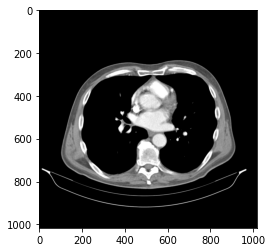

In [13]:
img = img_stack[0].cpu().numpy()
img = np.moveaxis(img, 0, 2)
plt.imshow(img)

## Analiza performante segmentare

In [ ]:
def load_dicom_slices(path_list):
    ans = np.zeros([len(path_list), 1017, 1017])
    idx = 0
    for dicom_path in path_list:
        datastore = dcmread(dicom_path)
        image = datastore.pixel_array
        if np.min(image) != np.max(image):
            relmin = np.min(image[image > np.min(image)])
            image[image == np.min(image)] = relmin
            image = (image - np.min(image)) / (np.max(image) - np.min(image))
            image[image > 0.01] = 1
        else:
            image = np.zeros(image.shape)
        ans[idx, :, :] = image
        idx = idx + 1

    return np.int16(ans)

In [ ]:
load_path = 'G:/MachineLearning/liver-sample-test/'
timpi_ct = ['NATIV', 'ARTERIAL', 'VENOS', 'PARENCHIMATOS']
dcnn = []
dge = []
for timp in timpi_ct:
    dicom_files_etalon = glob.glob(load_path + timp + '*CORECTAT*/*.dcm')
    dicom_files_cnn = glob.glob(load_path + timp + '*CNN*/*.dcm')
    dicom_files_ge = glob.glob(load_path + timp + '*GE*/*.dcm')

    dicom_etalon = load_dicom_slices(dicom_files_etalon)
    dicom_cnn = load_dicom_slices(dicom_files_cnn)
    dicom_ge = load_dicom_slices(dicom_files_ge)

    print('Statistici timp ' + timp)
    dice_cnn = np.sum(dicom_cnn[dicom_etalon==1])*2.0 / (np.sum(dicom_etalon) + np.sum(dicom_cnn))
    dcnn.append(dice_cnn)
    dice_ge = np.sum(dicom_ge[dicom_etalon==1])*2.0 / (np.sum(dicom_etalon) + np.sum(dicom_ge))
    dge.append(dice_ge)
    print(f'\tDICE DeepLabV3: {dice_cnn:.3f}')
    print(f'\tDICE GE: {dice_ge:.3f}\n')



In [ ]:
x = np.arange(len(timpi_ct))
width = 0.35

fig, ax = plt.subplots()
rect_cnn = ax.bar(x - width/2, dcnn, width, label='DeepLabV3')
rect_ge = ax.bar(x + width/2, dge, width, label='GE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('DICE Score')
ax.set_title('Scores by method')
ax.set_xticks(x, timpi_ct)
ax.legend()

# ax.bar_label(rect_cnn, padding=3)
# ax.bar_label(rect_ge, padding=3)

fig.tight_layout()

plt.ylim([0.6, 1.0])
plt.show()